# Notebook : Figures for paper "Characterization of internal tide non-stationarity : Eulerian versus Lagrangian perspectives"

Figures found in the paper (plus supplements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import os
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec



In [2]:
path = '/Users/zcaspar/codes/Diagnostics2/'
params_fitE = [xr.open_dataset(file) for file in sorted(glob(path+'wp*/'+'ZC_bootstrapE_v100_alpha.nc'))] #local
params_fitL = [xr.open_dataset(file) for file in sorted(glob(path+'wp*/'+'ZC_bootstrapL_v100_alpha.nc'))] #local
#dsv2_omega = [xr.open_dataset(file) for file in [path+'ZC_bootstrapE_v100_omega.nc',path+'ZC_bootstrapL_v100_omega.nc']] #local
#dsv2 = [xr.open_dataset(file) for file in sorted(glob(path+'wp*/'+'ZC_param_fit_T80_v2.nc'))] #local

In [3]:
#Model fitted
def myfit(tau,Tt,Xt,alpha,Tb,Xb):
    return np.cos(omega*tau)*Xt*(alpha+(1-alpha)*np.exp(-tau/Tt))+Xb*np.exp(-tau/Tb)

In [4]:
def phi_mu(tau,Tbar):
    return 1-np.exp(-tau/Tbar)
def phi_sigma(tau,Tbar):
    return 1-2*(1-np.exp(-tau/Tbar))*Tbar/tau+(1-np.exp(-2*tau/Tbar))*Tbar/(2*tau)

In [5]:
def r_E(tau,T):
    return tau/T
def T2(tau,Tb,Lt,U):
    return Tb**2*(2*np.pi/Lt)**2*(U*3600*24)**2*(tau/Tb-phi_mu(tau,Tb))
def Cth(tau,T,Tb,Lt,U,Xt,alpha):
    return Xt*(alpha+(1-alpha)*np.exp(-r_E(tau,T)))*np.exp(-T2(tau,Tb,Lt,U))
def Cth_reverse(tau,T,Tb,Lt,U,Xt,alpha):
    return Xt*(alpha+(1-alpha)*np.exp(-r_E(tau,T)))*np.exp(T2(tau,Tb,Lt,U))

#def ksigma(tau,T,Tb,Lt,U):
#    return T2(tau,Tb,Lt,U)

def Ctilde(tau,T,Tb,Lt,U,Xt_ns,Xt_s):
    return (Xt_s+Xt_ns*np.exp(-t1(tau,T)))*np.exp(-t2(tau,Tb,Lt,U)-t3(tau,Tb,Lt,U))
def C_fit(tau,Tt,Xt,alpha):
    return Xt*(alpha+(1-alpha)*np.exp(-tau/Tt))

In [6]:
def ksig_square(tau,Lt,Tb,Vb):
    return (Tb*(2*np.pi/Lt)*(Vb*3600*24))**2*(tau/Tb-(1-np.exp(-tau/Tb)))

In [7]:
tau = np.arange(0,40,10/(24*60))
omega = 2*np.pi*2
Tau = xr.DataArray(tau,dims='tau',coords={'tau':tau})

In [8]:
ce = 'lightseagreen'
cl = 'firebrick'

In [9]:
# Autocorrelatoin from data
corrE = xr.open_dataset(path+'wp7/'+'ZC_Eulerian_corr_80avg1d.nc').rename({'lags':'lag'})
corrL = xr.open_dataset(path+'wp7/'+'ZC_drifters_corr_80avg1d.nc')

In [10]:
for v in ['uu','vv']:
    corrE[v+'_normalized'] = corrE[v]/corrE[v].sel(lag=0)
    corrL[v+'_normalized'] = corrL[v]/corrL[v].sel(lag=0)
for v in ['uv','vu']:#
    corrE[v+'_normalized'] = corrE[v]/np.sqrt(corrE['uu'].sel(lag=0)*corrE['vv'].sel(lag=0))
    corrL[v+'_normalized'] = corrL[v]/np.sqrt(corrL['uu'].sel(lag=0)*corrL['vv'].sel(lag=0))


In [11]:
#Autocovariance and autocorrelation from fit without omega:
fit_E = myfit(Tau,params_fitE[-2]['Tt'],params_fitE[-2]['Xt'],
                    params_fitE[-2]['alpha'],params_fitE[-2]['Tb'],
                    params_fitE[-2]['Xb']
                   )
fit_L = myfit(Tau,params_fitL[-2]['Tt'],params_fitL[-2]['Xt'],
                    params_fitL[-2]['alpha'],params_fitL[-2]['Tb'],
                    params_fitL[-2]['Xb']
                   )

In [12]:
fit_E['normalized'] = fit_E/fit_E.sel(tau=0)
fit_L['normalized'] = fit_L/fit_L.sel(tau=0)
fit_E = fit_E.assign_coords({'y':fit_E.y*1e-3})

In [13]:
bootL = xr.open_dataset(path+'ZC_bootstrapL_v100_alpha.nc')
bootE = xr.open_dataset(path+'ZC_bootstrapE_v100_alpha.nc')
bootE = bootE.assign_coords({'y':bootE.y*1e-3})

In [14]:
paramsE = xr.concat(params_fitE,dim='wp').assign_coords({'y':params_fitE[0].y*1e-3+2,'wp':[0,1,2,3,4]})
paramsL = xr.concat(params_fitL,dim='wp').assign_coords({'wp':[0,1,2,3,4]}).rename({'y_cut':'y'})

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [15]:
vmodes = [xr.open_dataset(file) for file in sorted(glob(path+'wp*/'+'ZC_waves_modes*'))] #local
Lt = [vm.lwave.sel(mode=1)*1e3 for vm in vmodes]
Ltilde = [L.assign_coords({'y_bins' : L.y_rho*1e-3}) for L in Lt]
Lt_mean_omega = [L.groupby_bins('y_bins',paramsE.y+25,include_lowest=False).mean() for i,L in enumerate(Ltilde)]
Ltilde_mean_omega = [Ltm.assign_coords({'y_bins_bins':[yy.mid for yy in Ltm.y_bins_bins.values]}).rename({'y_bins_bins':'ybin'}) for Ltm in Lt_mean_omega]





In [16]:
Ltilde_mean = xr.concat(Ltilde_mean_omega,dim='wp',coords='minimal').assign_coords({'wp':[0,1,2,3,4]})

In [17]:
Ltilde_mean = Ltilde_mean.rename({'ybin':'y'})

In [18]:
C_fitE = C_fit(Tau,paramsE['Tt'],paramsE['Xt'],paramsE['alpha'])
C_fitL = C_fit(Tau,paramsL['Tt'],paramsL['Xt'],paramsL['alpha'])
C_thL = Cth(Tau,paramsE['Tt'],paramsL['Tb'],Ltilde_mean,np.sqrt(paramsL['Xb']),paramsE['Xt'],paramsE['alpha'])
C_thE = Cth_reverse(Tau,paramsL['Tt'],paramsL['Tb'],Ltilde_mean,np.sqrt(paramsL['Xb']),paramsL['Xt'],paramsL['alpha'])

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


In [19]:
C_comp = xr.Dataset(data_vars = {'fit_L':C_fitL,'fit_E':C_fitE,'thL':C_thL,'thE':C_thE})#,coords={'tau':C_fitE.tau.values,'wp':np.arange(0,5),'ybin':C_fit_E_omega.ybin.values})

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


### Figures 1 and 2 : cf synthesis/Summary_wp7.ipynb

### Figure 3 :

In [20]:
corrE = corrE.assign_coords({'y_bins':corrE.y_bins.values*1e-3})

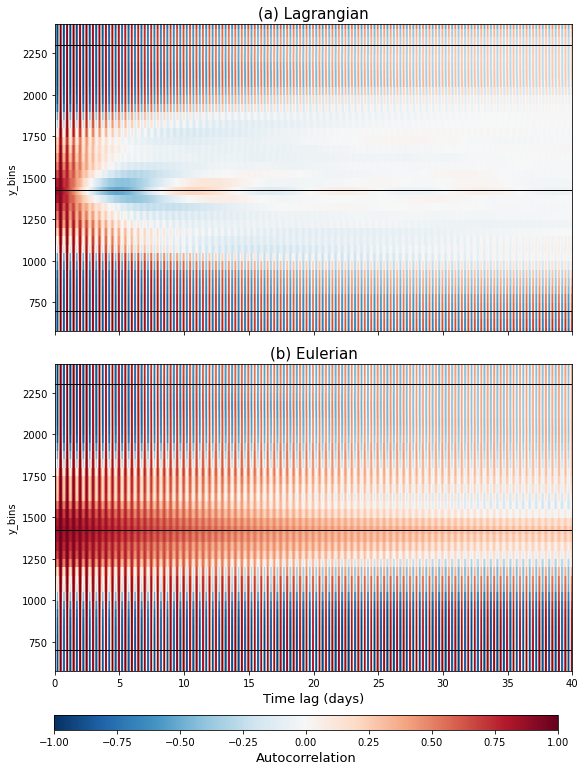

In [21]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ymax = corrL['uu_normalized'].dropna(dim='y_bins').y_bins.max()
ymin = corrL['uu_normalized'].dropna(dim='y_bins').y_bins.min()
V = 'vv'
#for V,i in zip(['uu','vv'],range(2)):
im = corrL[V+'_normalized'].plot(ax=ax[0],add_colorbar=False)#;ax[0].set_ylabel('')
corrE[V+'_normalized'].plot(ax=ax[1],add_colorbar=False)#;ax[1].set_ylabel('')
#[ax[0].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,40,4*0.5)]
#ax[i,0].set_title(r'$\;$',fontsize=15);ax[i,0].set_ylabel('y(km)',fontsize=13);
#ax[i,0].set_xlabel('',fontsize=13)
#[ax[1].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,40,2*0.5)]
#ax[i,1].set_title('',fontsize=15);ax[i,1].set_yticklabels('')#;ax[i,1].set_ylabel('y(m)',fontsize=15)
#ax[i,1].set_xlabel('',fontsize=13)
ax[0].set_ylim(ymin,ymax);ax[1].set_ylim(ymin,ymax)
for y in [700,1425,2300]:
    ax[0].axhline(y,c='k',linewidth=1)
    ax[1].axhline(y,c='k',linewidth=1)
ax[0].set_xlabel('')
ax[1].set_xlabel('Time lag (days)',fontsize=13)
ax[0].set_title('(a) Lagrangian',fontsize=15);ax[1].set_title('(b) Eulerian',fontsize=15);
ax[0].set_xticklabels('')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.08, -0.02, 0.7, 0.02])
cb = fig.colorbar(im, cax=cbar_ax,orientation = 'horizontal')#
cb.set_label('Autocorrelation',size=13)
#fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure3_review.png',bbox_inches='tight')




## Figure 4 : 

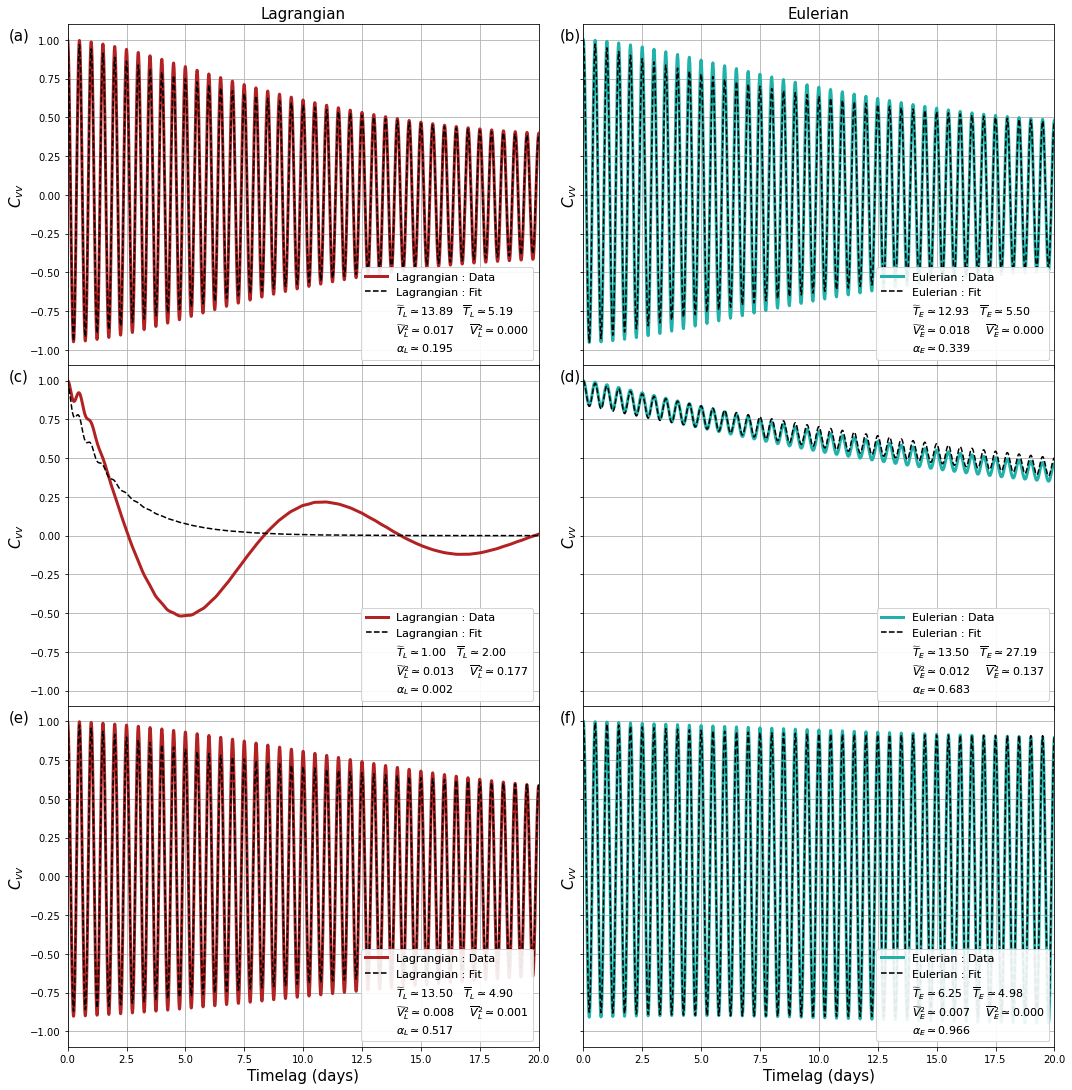

In [22]:
import matplotlib as mpl
from matplotlib.patches import Rectangle

ce_fit = 'k'
cl_fit='k'
#Sections
Y=[2300,1425,700]

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

# place a text box in upper left in axes coords

V = 'vv'
fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,yy in enumerate(Y):
    #for V,ax in zip(['uu','vv'],axs[i,:]):
    #for V in zip(['uu','vv'],axs[i,:]):
    paE = paramsE.sel(wp=3).sel(y=yy,method='nearest')
    paL = paramsL.sel(wp=3).sel(y=yy,method='nearest')
    textstrE = '\n'.join((
            r'$\widetilde{T}_E\simeq%.2f\hspace{1}\overline{T}_E\simeq%.2f$' % (paE.Tt.values, paE.Tb.values),
            r'$\widetilde{V}^2_E\simeq%.3f\hspace{1.5}\overline{V}^2_E\simeq%.3f$' % (paE.Xt.values,paE.Xb.values),
            #r'$\widetilde{V}_{s,E}\simeq%.3f\hspace{1.5}\Omega_E\simeq%.2f$'% (np.sqrt(paE[2]/2),paE[5])
            r'$\alpha_E\simeq%.3f$'% (paE.alpha.values)
                            ))
    textstrL = '\n'.join((
            r'$\widetilde{T}_L\simeq%.2f\hspace{1}\overline{T}_L\simeq%.2f$' % (paL.Tt.values, paL.Tb.values),
            r'$\widetilde{V}^2_L\simeq%.3f\hspace{1.5}\overline{V}^2_L\simeq%.3f$' % ((paL.Xt.values),(paL.Xb.values)),
#            r'$\widetilde{V}_{s,L}\simeq%.3f\hspace{1.5}\Omega_L\simeq%.2f$'% (np.sqrt(paL[2]),paL[5])
            r'$\alpha_L\simeq%.3f$'% (paL.alpha.values)
                            ))
    corrE[V+'_normalized'].sel(y_bins=yy,method='nearest').plot(c=ce,linewidth = 3,ax=axs[i,1],label=('Eulerian : Data'))
    fit_E['normalized'].sel(y=yy,method='nearest').plot(c = ce_fit,linestyle='--',ax=axs[i,1],label=('Eulerian : Fit'))
    corrL[V+'_normalized'].sel(y_bins=yy,method='nearest').plot(c=cl,linewidth = 3,ax=axs[i,0],label=('Lagrangian : Data'))
    fit_L['normalized'].sel(y_cut=yy,method='nearest').plot(c=cl_fit,linestyle='--',ax=axs[i,0],label=('Lagrangian : Fit'))
    handles,labels = axs[i,0].get_legend_handles_labels()
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    legendL = axs[i,0].legend(handles[:]+[extra],labels[:]+[textstrL],loc='lower right',framealpha=0.7,fontsize=11)
    axs[i,0].add_artist(legendL)
    handles,labels = axs[i,1].get_legend_handles_labels()
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    legendE = axs[i,1].legend(handles[:]+[extra],labels[:]+[textstrE],loc='lower right',framealpha=0.7,fontsize=11);
    axs[i,1].add_artist(legendE)
    for ax in axs[i,:]:
        ax.set_ylim(-1.1,1.1);ax.grid();ax.set_title('')
        ax.set_ylabel(r'$C_{%s}$'%V,fontsize=15);ax.set_xlabel('Timelag (days)',fontsize=15)
        ax.set_xlim(0,20)
        
fig.tight_layout()
for ax,txt in zip(axs[:,0],['(a)','(c)','(e)']):
    ax.text(-2.5,1,txt,fontsize=15)
for ax,txt in zip(axs[:,1],['(b)','(d)','(f)']):
    ax.text(-1.,1,txt,fontsize=15)
axs[0,0].set_title('Lagrangian',fontsize=15)
axs[0,1].set_title('Eulerian',fontsize=15)
fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure4_review2.pdf',bbox_inches='tight')

Caption : Normalized autocorrelation at fixed bin in three different area : north (a and b), center (c and d) and south (e and f) of the domain). The eulerian and lagrangian autocorrelation derived from our data are represented respectively in blue and red. The best fits found with our theoretical model are plotted in grey dashed lines.

## Figure 5 : 

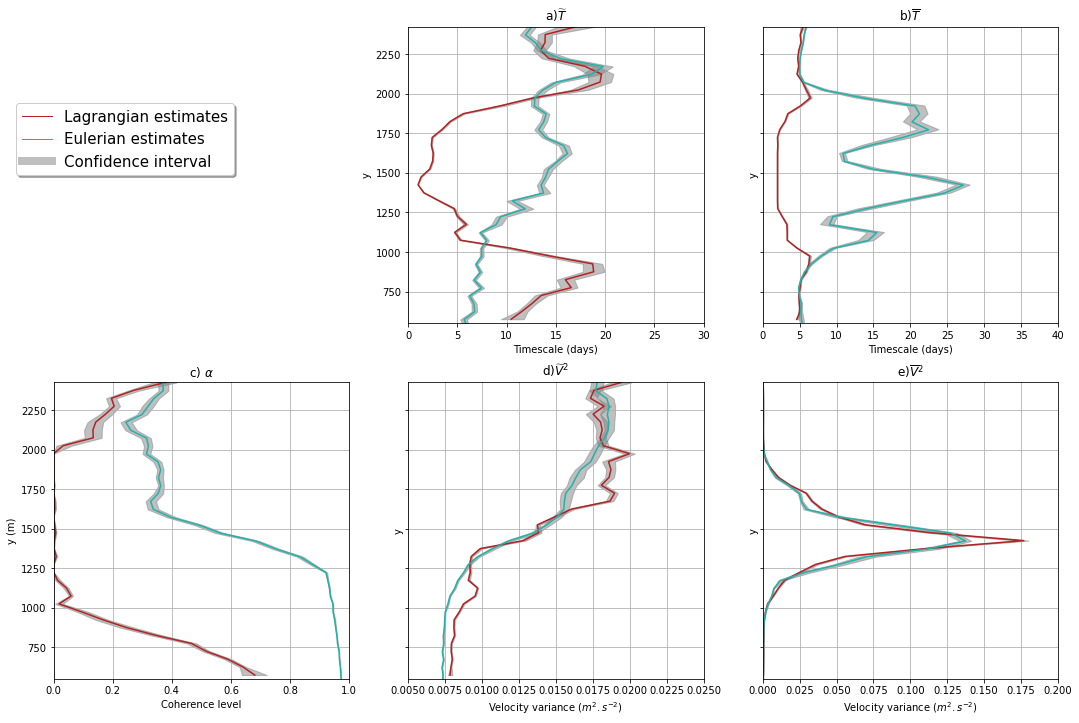

In [23]:
from matplotlib.lines import Line2D

lims = [[0,30],[0,40],[0.005,0.025],[0,0.2]]
fig,axs = plt.subplots(2,3,figsize=(18,12))
for V,ax,title,lim in zip(['Tt','Tb'],axs[0,1:],[r'a)$\widetilde{T}$',r'b)$\overline{T}$'],lims[:2]):
    ax.fill_betweenx(bootL.y_cut,bootL[V+'_lower'],bootL[V+'_upper'],color='grey',alpha=0.5)
    bootL[V].plot(ax=ax,c='firebrick',y='y_cut')
    ax.fill_betweenx(bootE.y,bootE[V+'_lower'],bootE[V+'_upper'],color='grey',alpha=0.5)
    bootE[V].plot(ax=ax,c='lightseagreen',y='y')
    ax.grid();ax.set_title(title);ax.set_xlim(lim);ax.set_ylim(550,2425)
    ax.set_xlabel('Timescale (days)')

for V,ax,title,lim in zip(['Xt','Xb'],axs[1,1:],[r'd)$\widetilde{V}^2$',
                                                 r'e)$\overline{V}^2$'],lims[2:]):
    ax.fill_betweenx(bootL.y_cut,(bootL[V+'_lower'].where((bootL[V+'_lower'])>0).fillna(0))
                     ,(bootL[V+'_upper']),color='grey',alpha=0.5)
    (bootL[V]).plot(ax=ax,c='firebrick',y='y_cut')
    ax.fill_betweenx(bootE.y,(bootE[V+'_lower']),(bootE[V+'_upper']),color='grey',alpha=0.5)
    (bootE[V]).plot(ax=ax,c='lightseagreen',y='y')
    ax.grid();ax.set_title(title);ax.set_xlim(lim);ax.set_ylim(550,2425)
    ax.set_xlabel(r'Velocity variance ($m^2.s^{-2}$)')
ax = axs[1,0]
V='alpha'
ax.fill_betweenx(bootL.y_cut,bootL[V+'_lower'].where(bootL[V+'_lower']>0).fillna(0)
                     ,(bootL[V+'_upper']),color='grey',alpha=0.5)
(bootL[V]).plot(ax=ax,c='firebrick',y='y_cut')
ax.fill_betweenx(bootE.y,(bootE[V+'_lower']),(bootE[V+'_upper']),color='grey',alpha=0.5)
(bootE[V]).plot(ax=ax,c='lightseagreen',y='y')
ax.grid();ax.set_title(r'c) $\alpha$');
ax.set_xlim([0,1]);ax.set_ylim(550,2425)
ax.set_xlabel(r'Coherence level')
fig.delaxes(axs[0,0])
labels = ['Lagrangian estimates','Eulerian estimates','Confidence interval ']
custom_lines = [Line2D([0], [0], color='firebrick', lw=1),
                Line2D([0], [0], color='lightseagreen', lw=1),
                Line2D([0], [0], color='grey', lw=8,alpha=0.5
                      )]
plt.setp(axs[1,1].get_yticklabels(),visible=False)
plt.setp(axs[1,2].get_yticklabels(),visible=False)
plt.setp(axs[0,2].get_yticklabels(),visible=False)
axs[0,0].set_ylabel('y (m)')
axs[1,0].set_ylabel('y (m)')
fig.legend(custom_lines, labels, bbox_to_anchor=((0.27,0.8)),fontsize=15,fancybox=True,shadow=True)
fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/'+'Figure5_review2.pdf',bbox_inches='tight')

## Figure 6

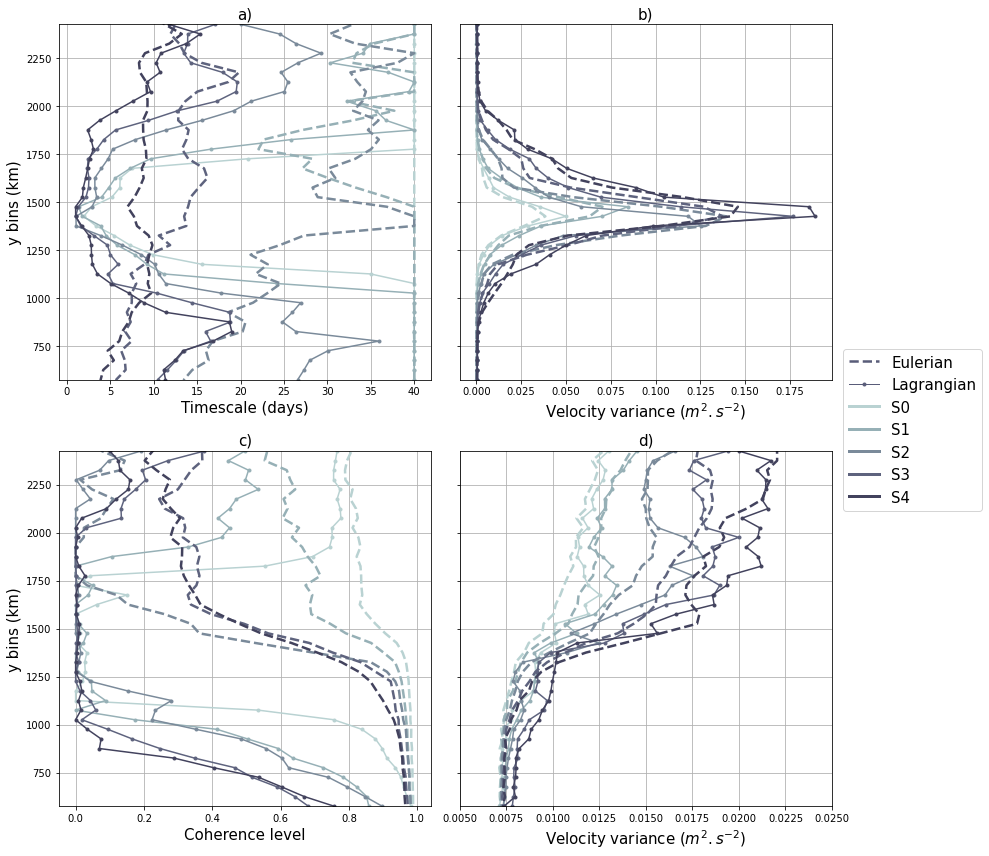

In [24]:
number = paramsE.wp.values.size
cmap_Ta = plt.get_cmap('Greys')
cmap = plt.get_cmap('bone_r')
#colors_Ta = [cmap_Ta(i) for i in np.linspace(0.5, 1, number)]
colors = [cmap(i) for i in np.linspace(0.2, .7, number)]


width_E=2.5
alpha_L = 1.
alpha_E = 1.

lims_vv = [(0,40),(0,0.35),(0,0.12),(0,0.12)]
size=15
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)


axT = fig.add_subplot(spec[0:2,0:2])
axVb = fig.add_subplot(spec[0:2,2:4],sharey=axT)
axalpha = fig.add_subplot(spec[2:4,0:2])
axVt = fig.add_subplot(spec[2:4,2:],sharey=axalpha)


labels = ['Eulerian','Lagrangian']
#cmap = plt.get_cmap('bone')
custom_lines = [
                Line2D([0], [0], color=cmap(.6), lw=width_E,linestyle ='--'),
                Line2D([0], [0], color=cmap(.6), lw=1,marker='.')
               ]
ymax = np.min([paramsL.sel(wp=i).dropna(dim='y').y.max() for i in paramsL.wp])
ymin = np.max([paramsL.sel(wp=i).dropna(dim='y').y.min() for i in paramsL.wp])
titles= [r'a)',r'b)', r'c)',
         r'd)']

for i in paramsE.wp.values:
    paramsL['Tt'].sel(wp=i).plot(y='y',c=colors[i],ax=axT,marker='.',alpha=alpha_L)
    paramsE['Tt'].sel(wp=i).plot(y='y',c=colors[i],ax=axT,linestyle='--',linewidth=width_E,alpha=alpha_E)
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=3))
    labels.append('S%s'% i)
    for ax,pa in zip([axVb,axalpha,axVt],['Xb','alpha','Xt']):
        ((paramsL[pa].sel(wp=i))).plot(y='y',c=colors[i],ax=ax,marker='.',alpha=alpha_L)
        ((paramsE[pa].sel(wp=i))).plot(y='y', c=colors[i],ax=ax,linestyle='--',linewidth=width_E,alpha=alpha_E)
    
for ax,title in zip([axT,axVb,axalpha,axVt],titles):   
    ax.grid();ax.set_title(title,fontsize=size);ax.set_ylabel('');
    ax.set_ylim(ymin,ymax)
axVt.set_xlabel(r'Velocity variance ($m^2.s^{-2}$)',fontsize=size)
axVb.set_xlabel(r'Velocity variance ($m^2.s^{-2}$)',fontsize=size)
axalpha.set_xlabel(r'Coherence level',fontsize=size)
axT.set_xlabel('Timescale (days)',fontsize=size)
axT.set_ylabel('y bins (km)',fontsize=size)
axalpha.set_ylabel('y bins (km)',fontsize=size)
axVt.set_xlim(0.005,0.025)
plt.setp(axVb.get_yticklabels(),visible=False)
plt.setp(axVt.get_yticklabels(),visible=False)

fig.legend(custom_lines, labels, bbox_to_anchor=((1.15,.6)),fontsize=size)
fig.tight_layout()
plt.show()
fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure6_review2.pdf',bbox_inches='tight')

## Figure 7 

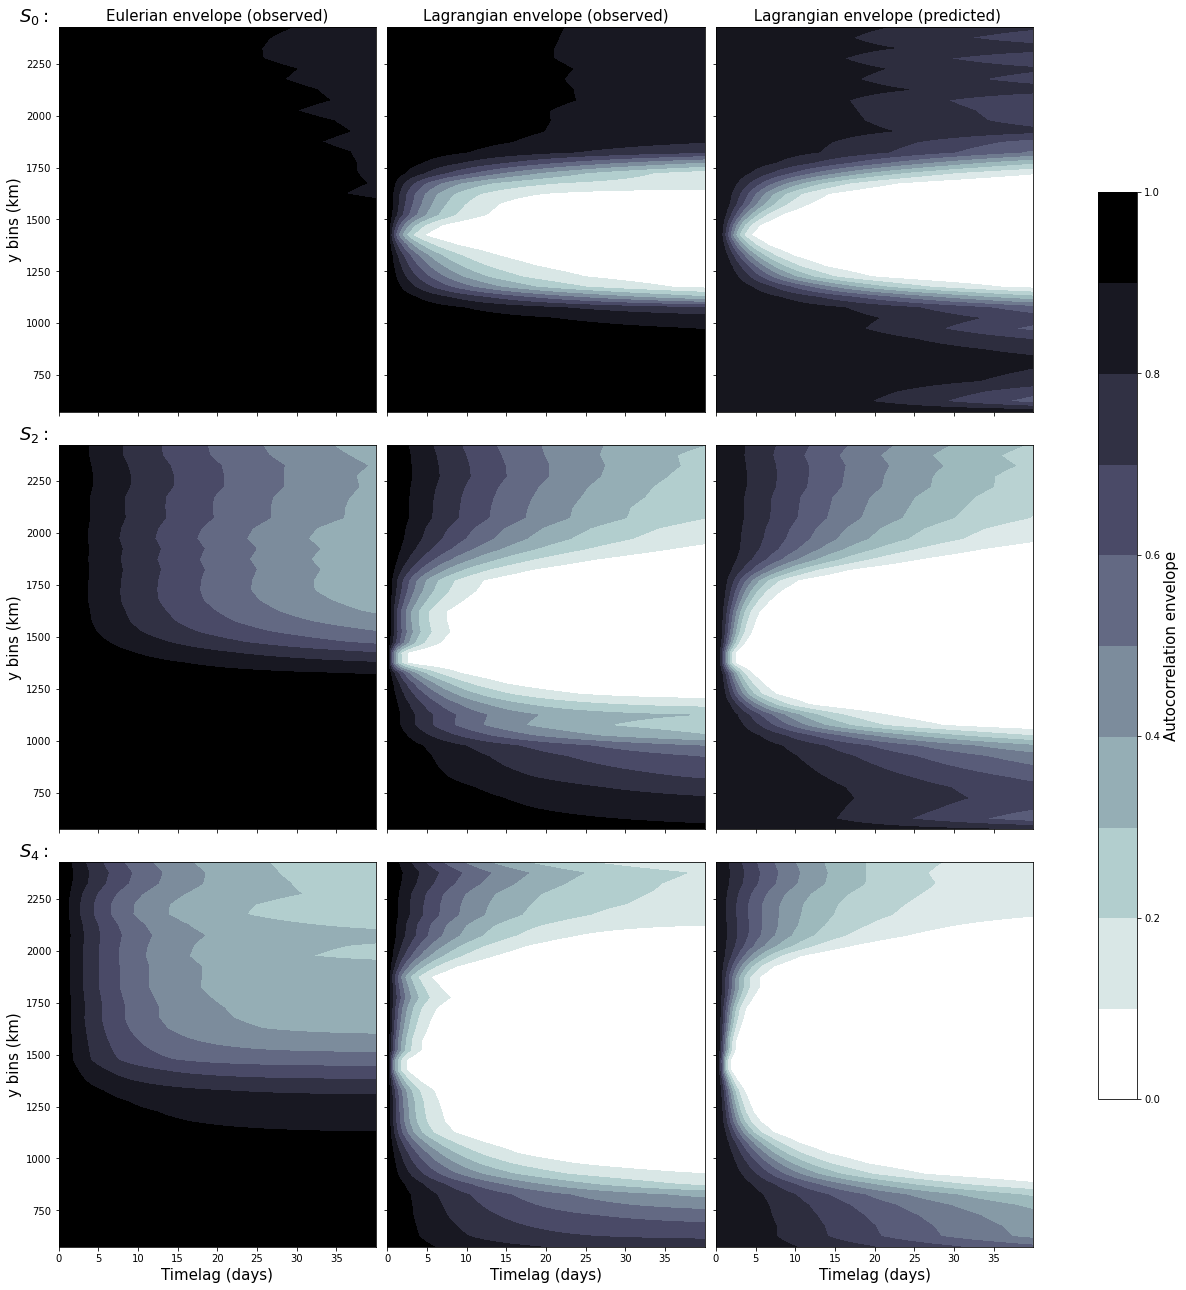

In [32]:
size = 15
cmap = 'bone_r'
lev=11
fig,axs = plt.subplots(3,3,figsize=(18,18),sharey=True,sharex=True)
for i,S in enumerate(C_comp.wp.values[::2]):
    ax = axs[i,:]
    m = 0
    M = 1
    im = (C_comp.fit_E.sel(wp=S)/C_comp.fit_E.sel(wp=S).isel(tau=0)).dropna(dim='y').plot.contourf(ax=ax[0],vmin=m,vmax=M,cmap=cmap,levels=lev,add_colorbar=False)
    (C_comp.fit_L.sel(wp=S)/C_comp.fit_L.sel(wp=S).isel(tau=0)).dropna(dim='y').plot.contourf(ax=ax[1],vmin=m,vmax=M,cmap=cmap,levels=lev,add_colorbar=False)
    (C_comp.thL.sel(wp=S)/C_comp.thL.sel(wp=S).isel(tau=1)).dropna(dim='y').plot.contourf(ax=ax[2],vmin=m,vmax=M,cmap=cmap,levels=lev,add_colorbar=False)
     
    for a in ax:
        a.set_xlabel('',fontsize=size);a.set_ylim(C_comp.fit_L.dropna(dim='y').y.min(),
                                                  C_comp.fit_L.dropna(dim='y').y.max())
        a.set_title('');a.set_ylabel('')
    ax[0].set_ylabel('y bins (km)',fontsize=size)
axs[2,0].set_xlabel('Timelag (days)',fontsize=size);axs[2,1].set_xlabel('Timelag (days)',fontsize=size);
axs[2,2].set_xlabel('Timelag (days)',fontsize=size)
axs[0,0].text(-5,2450,r'$S_0 : $',size=18)
axs[1,0].text(-5,2450,r'$S_2 : $',size=18)
axs[2,0].text(-5,2450,r'$S_4 : $',size=18)
for ax,title in zip(axs[0,:],['Eulerian envelope (observed)','Lagrangian envelope (observed)',' Lagrangian envelope (predicted)']):
    ax.set_title(title ,fontsize=size)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Autocorrelation envelope',size=size)
fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure7_review2.png',bbox_inches='tight')

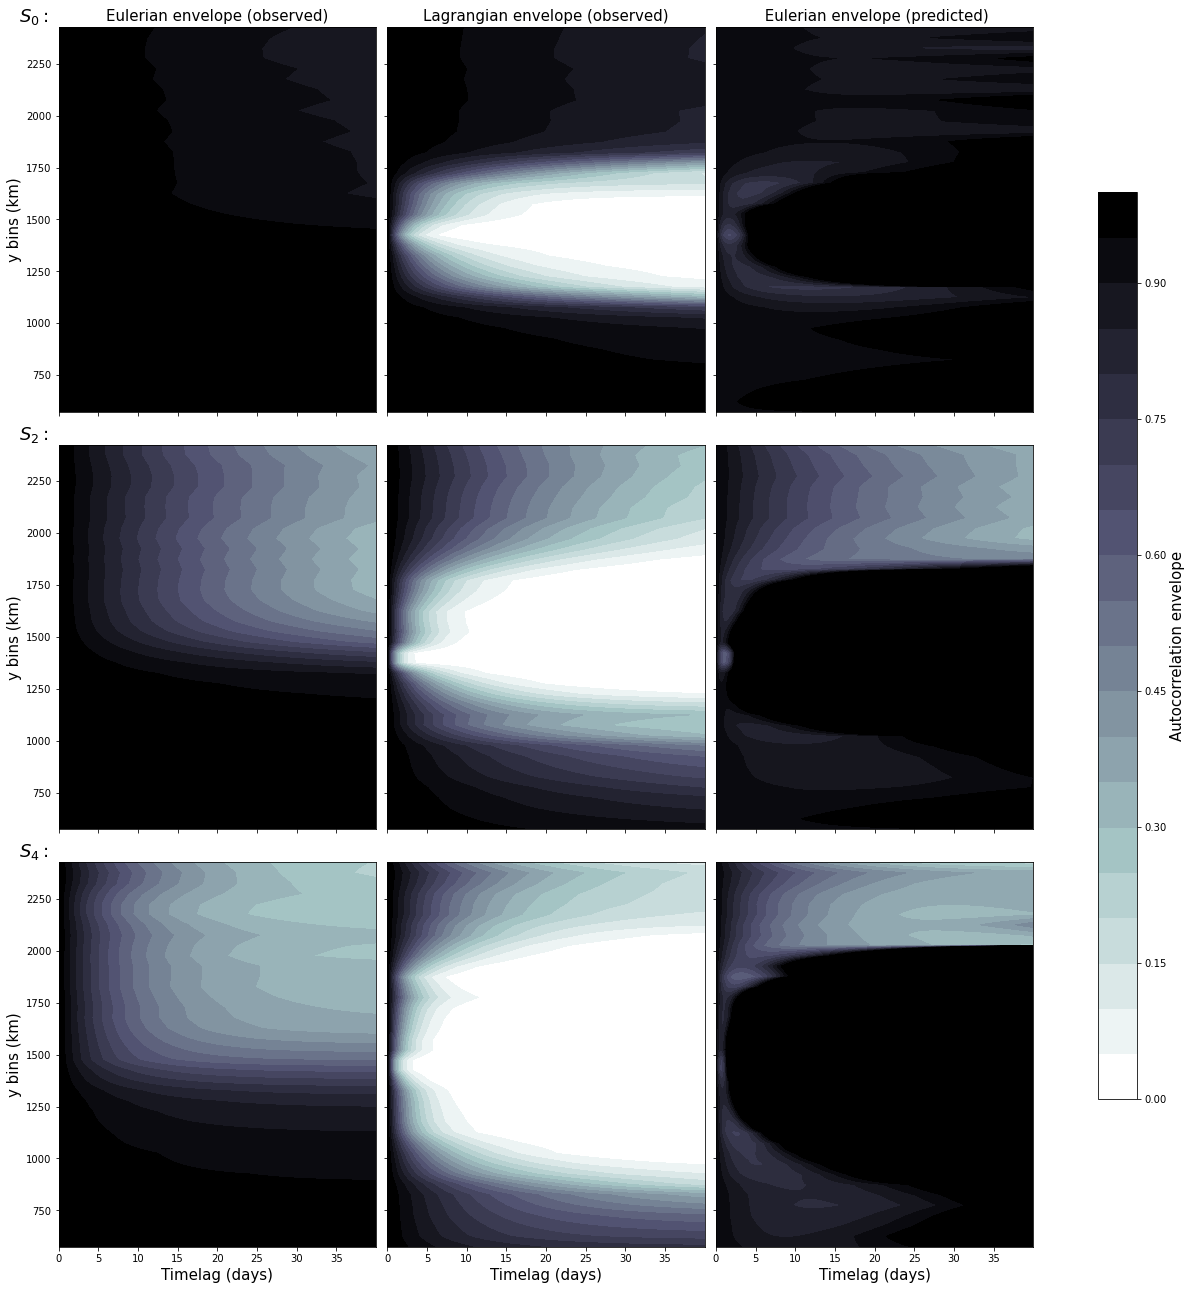

In [73]:
size = 15
cmap = 'bone_r'
lev=1
fig,axs = plt.subplots(3,3,figsize=(18,18),sharey=True,sharex=True)
for i,S in enumerate(C_comp.wp.values[::2]):
    ax = axs[i,:]
    m = 0
    M = 1
    im = (C_comp.fit_E.sel(wp=S)/C_comp.fit_E.sel(wp=S).isel(tau=0)).dropna(dim='y').plot.contourf(ax=ax[0],vmin=m,vmax=M,cmap=cmap,levels=lev,add_colorbar=False)
    (C_comp.fit_L.sel(wp=S)/C_comp.fit_L.sel(wp=S).isel(tau=0)).dropna(dim='y').plot.contourf(ax=ax[1],vmin=m,vmax=M,cmap=cmap,levels=lev,add_colorbar=False)
    (C_comp.thE.sel(wp=S)/C_comp.thE.sel(wp=S).isel(tau=1)).dropna(dim='y').plot.contourf(ax=ax[2],vmin=m,vmax=M,cmap=cmap,levels=lev,add_colorbar=False)
     
    for a in ax:
        a.set_xlabel('',fontsize=size);a.set_ylim(C_comp.fit_L.dropna(dim='y').y.min(),
                                                  C_comp.fit_L.dropna(dim='y').y.max())
        a.set_title('');a.set_ylabel('')
    ax[0].set_ylabel('y bins (km)',fontsize=size)
axs[2,0].set_xlabel('Timelag (days)',fontsize=size);axs[2,1].set_xlabel('Timelag (days)',fontsize=size);
axs[2,2].set_xlabel('Timelag (days)',fontsize=size)
axs[0,0].text(-5,2450,r'$S_0 : $',size=18)
axs[1,0].text(-5,2450,r'$S_2 : $',size=18)
axs[2,0].text(-5,2450,r'$S_4 : $',size=18)
for ax,title in zip(axs[0,:],['Eulerian envelope (observed)','Lagrangian envelope (observed)',' Eulerian envelope (predicted)']):
    ax.set_title(title ,fontsize=size)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Autocorrelation envelope',size=size)
#fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure7_review2.png',bbox_inches='tight')

In [69]:
#ksig_square(Tau,Ltilde_mean,paramsL['Tb'],np.sqrt(paramsL['Xb']))
#(1-paramsL['alpha'])*np.exp(-Tau/paramsL['Tt'])
paramsL['Xt']*(paramsL['alpha']+(1-paramsL['alpha'])*np.exp(-Tau/paramsL['Tt']))

<xarray.DataArray (wp: 5, y: 39, tau: 5760)>
array([[[0.00713875, 0.00713873, 0.00713871, ..., 0.00705488,
         0.00705487, 0.00705487],
        [0.00723993, 0.00723989, 0.00723985, ..., 0.00710025,
         0.00710023, 0.00710022],
        [0.00731187, 0.00731182, 0.00731177, ..., 0.00712579,
         0.00712577, 0.00712576],
        ...,
        [0.01244508, 0.01244456, 0.01244404, ..., 0.0105605 ,
         0.01056031, 0.01056012],
        [0.01300381, 0.01300328, 0.01300275, ..., 0.01107458,
         0.01107438, 0.01107419],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00737706, 0.00737688, 0.0073767 , ..., 0.00671511,
         0.00671504, 0.00671498],
        [0.00741027, 0.00741008, 0.00740988, ..., 0.00671443,
         0.00671436, 0.00671428],
        [0.00739495, 0.00739472, 0.00739449, ..., 0.00656664,
         0.00656656, 0.00656647],
        ...,
        [0.01411277, 0.01411141, 0.01411006, ..., 0.0091816 ,
         0.00918111, 0.00918061],
        [0.01452941, 0.01452813, 0.01452686, ..., 0.00989478,
         0.00989431, 0.00989384],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00734185, 0.00734165, 0.00734145, ..., 0.0067509 ,
         0.00675086, 0.00675082],
        [0.00741261, 0.00741232, 0.00741203, ..., 0.00653865,
         0.00653858, 0.00653852],
        [0.00748591, 0.00748553, 0.00748514, ..., 0.00631636,
         0.00631627, 0.00631618],
        ...,
        [0.01539077, 0.01538683, 0.01538289, ..., 0.00420386,
         0.00420309, 0.00420232],
        [0.01658273, 0.01657809, 0.01657345, ..., 0.00500415,
         0.00500352, 0.00500289],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00783288, 0.00783122, 0.00782956, ..., 0.00538675,
         0.00538671, 0.00538668],
        [0.00789368, 0.00789198, 0.00789028, ..., 0.0051516 ,
         0.00515155, 0.0051515 ],
        [0.00798537, 0.00798356, 0.00798175, ..., 0.00484493,
         0.00484486, 0.00484478],
        ...,
        [0.01757349, 0.01756709, 0.0175607 , ..., 0.00547716,
         0.0054768 , 0.00547644],
        [0.01940931, 0.01940439, 0.01939947, ..., 0.00847764,
         0.00847717, 0.00847669],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00739489, 0.00739378, 0.00739268, ..., 0.00564   ,
         0.00563996, 0.00563993],
        [0.00799795, 0.00799629, 0.00799464, ..., 0.0054218 ,
         0.00542176, 0.00542171],
        [0.00788871, 0.00788696, 0.00788521, ..., 0.00488293,
         0.00488286, 0.00488279],
        ...,
        [0.0217205 , 0.02171191, 0.02170332, ..., 0.0041255 ,
         0.00412487, 0.00412423],
        [0.01999568, 0.01998506, 0.01997444, ..., 0.00259418,
         0.00259383, 0.00259347],
        [0.02410018, 0.02408764, 0.0240751 , ..., 0.00120398,
         0.00120335, 0.00120272]]])
Coordinates:
  * y        (y) float64 575.0 625.0 675.0 ... 2.375e+03 2.425e+03 2.475e+03
  * wp       (wp) int64 0 1 2 3 4
  * tau      (tau) float64 0.0 0.006944 0.01389 0.02083 ... 39.98 39.99 39.99

In [70]:
th_E = (paramsL['Xt']*(paramsL['alpha']+(1-paramsL['alpha'])*np.exp(-Tau/paramsL['Tt']))*np.exp(ksig_square(Tau,Ltilde_mean,paramsL['Tb'],np.sqrt(paramsL['Xb']))))

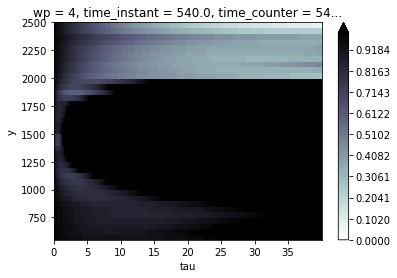

In [71]:
(th_E/th_E.isel(tau=0)).sel(wp=4).plot(vmax=1,vmin=0,levels=50,cmap='bone_r')

## Figure 8

In [34]:
tau_bis = np.arange(0,800,5/(24*60))
omega = 2*np.pi*2
Tau_bis = xr.DataArray(tau_bis,dims='tau',coords={'tau':tau_bis})

In [35]:
ymin = params_fitL[0].dropna(dim='y_cut').y_cut.min().values
ymax = params_fitL[0].dropna(dim='y_cut').y_cut.max().values

In [36]:
ksig_square(Tau_bis,Ltilde_mean.sel(wp=i),paramsL.sel(wp=i).Tb,np.sqrt(paramsL.sel(wp=i).Xb))

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


<xarray.DataArray (y: 39, tau: 230400)>
array([[0.00000000e+00, 2.55587057e-09, 1.02217911e-08, ...,
        2.35234275e+00, 2.35235305e+00, 2.35236335e+00],
       [0.00000000e+00, 6.68977815e-09, 2.67570054e-08, ...,
        1.28081521e+01, 1.28082088e+01, 1.28082654e+01],
       [0.00000000e+00, 6.90289159e-09, 2.76081329e-08, ...,
        8.42729927e+00, 8.42733628e+00, 8.42737329e+00],
       ...,
       [0.00000000e+00, 7.59404388e-09, 3.03721854e-08, ...,
        8.78189343e+00, 8.78193197e+00, 8.78197052e+00],
       [0.00000000e+00, 4.29951975e-09, 1.71956985e-08, ...,
        4.72100722e+00, 4.72102792e+00, 4.72104863e+00],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * y             (y) float64 575.0 625.0 675.0 ... 2.425e+03 2.475e+03
    wp            int64 2
    time_instant  float64 540.0
    time_counter  float64 540.0
    mode          int64 1
  * tau           (tau) float64 0.0 0.003472 0.006944 ... 800.0 800.0 800.0

In [37]:
ksigma = xr.concat([ksig_square(Tau_bis,Ltilde_mean.sel(wp=i),
                                paramsL.sel(wp=i).Tb,
                                np.sqrt(paramsL.sel(wp=i).Xb)) for i in paramsE.wp.values],dim='wp').assign_coords({'wp':[0,1,2,3,4]})

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureW

In [38]:
ksig = [ksigma[i].drop('time_instant') for i in [0,1]]
ksig.append(ksigma[2])
ksig.append(ksigma[3].drop('time_instant'))
ksig.append(ksigma[4].drop('time_instant'))

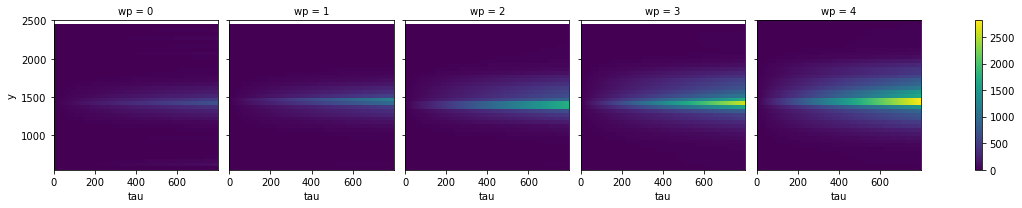

In [31]:
ksigma.plot(col='wp')

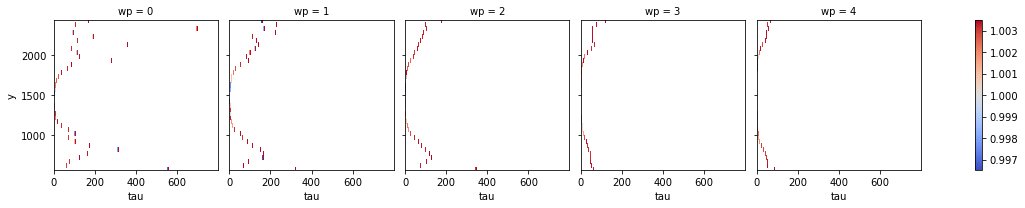

In [32]:
eps = 5/(60*24)
ksigma.where((ksigma>1-eps)&(ksigma<1+eps)).plot(col='wp',ylim=(ymin,ymax),cmap='coolwarm')
#ksigma.sel(wp=2).where((ksigma.sel(wp=2)>=1-eps),drop=True).plot()

In [39]:
ksigma = ksigma.sel(y=slice(ymin,ymax))

In [40]:
eps = 10/(60*24)

In [41]:
w = 4
tau_4 = xr.concat([ksigma.sel(wp=w,y=y).where((ksigma.sel(wp=w,y=y)>1-eps)
                                               &(ksigma.sel(wp=w,y=y)<1+eps),drop=True
                                              ).tau.mean() for y in ksigma.y.values],dim='y')

In [42]:
w = 0
tau_0 = xr.concat([ksigma.sel(wp=w,y=y).where((ksigma.sel(wp=w,y=y)>1-eps)
                                               &(ksigma.sel(wp=w,y=y)<1+eps),drop=True
                                              ).tau.mean() for y in ksigma.y.values],dim='y')

In [43]:
w = 1
tau_1 = xr.concat([ksigma.sel(wp=w,y=y).where((ksigma.sel(wp=w,y=y)>1-eps)
                                               &(ksigma.sel(wp=w,y=y)<1+eps),drop=True
                                              ).tau.mean() for y in ksigma.y.values],dim='y')
w = 2
tau_2 = xr.concat([ksigma.sel(wp=w,y=y).where((ksigma.sel(wp=w,y=y)>1-eps)
                                               &(ksigma.sel(wp=w,y=y)<1+eps),drop=True
                                              ).tau.mean() for y in ksigma.y.values],dim='y')
w = 3
tau_3 = xr.concat([ksigma.sel(wp=w,y=y).where((ksigma.sel(wp=w,y=y)>1-eps)
                                               &(ksigma.sel(wp=w,y=y)<1+eps),drop=True
                                              ).tau.mean() for y in ksigma.y.values],dim='y')

In [44]:
tau_inc = [tau_0,tau_1,tau_2,tau_3,tau_4]

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureW

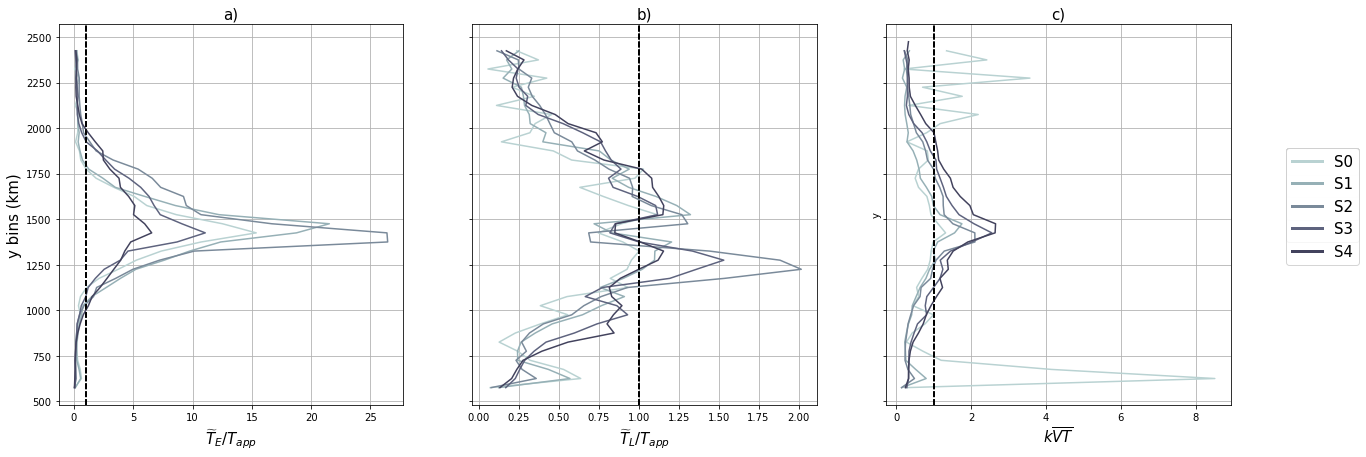

In [45]:
size=15
number = paramsE.wp.values.size
cmap_Ta = plt.get_cmap('Greys')
cmap = plt.get_cmap('bone_r')
#colors_Ta = [cmap_Ta(i) for i in np.linspace(0.5, 1, number)]
colors = [cmap(i) for i in np.linspace(0.2, .7, number)]


width_E=2.5
alpha_L = 1.
alpha_E = 1.


#for V in ['_u_avg','_v_avg']:
fig,ax = plt.subplots(1,3,figsize=(21,7),sharey=True)
labels = []

custom_lines = []
for i in paramsE.wp.values:
        #x1 = np.sqrt(d['E'+V].sel(param='Vt_ns')/d['E'+V].sel(param='Vt_s'))
    x3 = ((24*3600*paramsL.sel(wp=i).Tb*np.sqrt(paramsL.sel(wp=i).Xb)*2*np.pi/Ltilde_mean.sel(wp=i)))
    x1 = paramsE.sel(wp=i).sel(y=slice(ymin,ymax)).Tt/tau_inc[i]
    x2 = paramsL.sel(wp=i).sel(y=slice(ymin,ymax)).Tt/tau_inc[i]
    (x1).plot.line('-',ax=ax[0],y='y',c=colors[i])
    (x2).plot.line('-',ax=ax[1],y='y',c=colors[i])
    (x3).plot.line('-',ax=ax[2],y='y',c=colors[i])
        #x3.plot.line('-',ax=ax[2],y='ybin',c=colors[i])
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=3))
    labels.append('S%s'% i)
    ax[0].grid();ax[1].grid();ax[2].grid()
    ax[0].axvline(1,c='k',linestyle='--');ax[1].axvline(1,c='k',linestyle='--');
    ax[2].axvline(1,c='k',linestyle='--')
    ax[2].set_xlabel(r'$k\overline{V} \overline{T}$',fontsize=size);
    ax[0].set_xlabel(r'$\widetilde{T}_E/T_{app}$',fontsize=size);
    ax[1].set_xlabel(r'$\widetilde{T}_L/T_{app}$',fontsize=size)
    #ax[2].set_xlabel(r'$k^2\overline{V}^2\overline{T}_L^2(\widetilde{T}_L/\overline{T}_L-\phi_{\mu}(\widetilde{T}_L/\overline{T}_L))$',fontsize=size);
    ax[0].set_ylabel('y bins (km)',fontsize=size);ax[1].set_ylabel('')
    ax[0].set_title('a)',fontsize=size);ax[1].set_title('b)',fontsize=size)
    ax[2].set_title('c)',fontsize=size)
    fig.legend(custom_lines, labels, bbox_to_anchor=((.99,0.65)),fontsize=size)
fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure8_review2_bis.pdf',bbox_inches='tight')